In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import poly1d, polyfit, power
import scipy.optimize
from math import *
from IPython.display import HTML
from IPython.display import Image
import os
import pandas as pd
import PIL as pil
import heapq
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 18, 14
# import seaborn as sns
# sns.set_palette("deep", desat=.6)

try:
    from PIL import Image
except:
    import Image
    
incl = 40.

sin_i2 = np.sin(incl*np.pi/180.)**2
cos_i2 = np.cos(incl*np.pi/180.)**2

[]

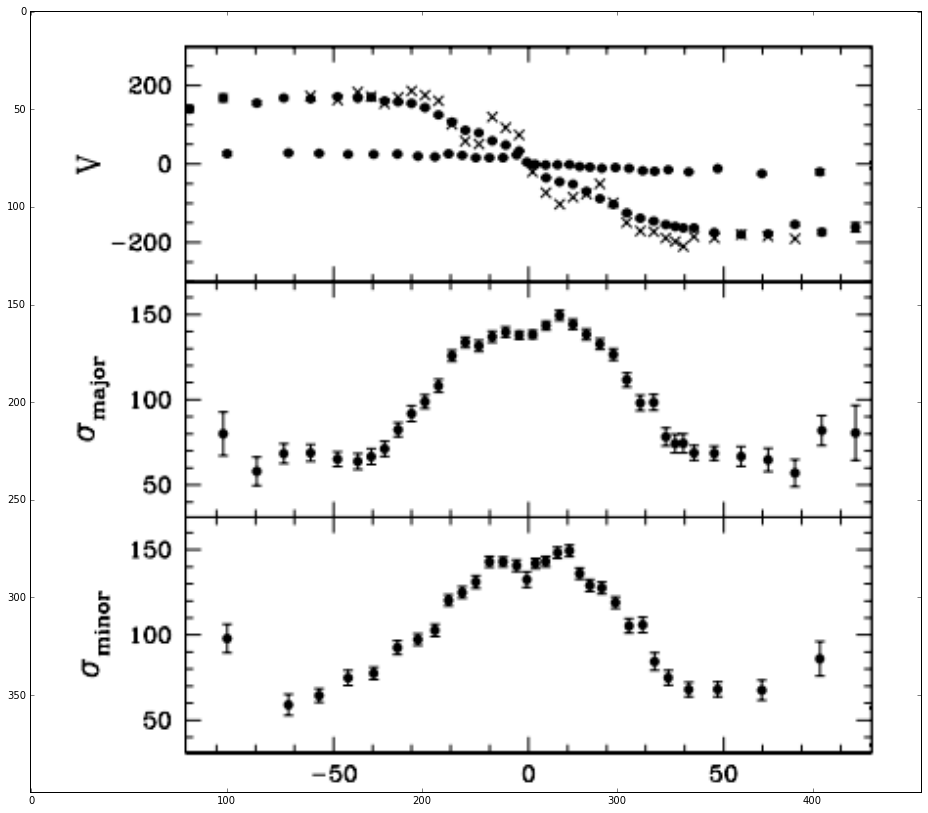

In [2]:
os.chdir("C:\\science\\2FInstability\\data\\ngc2775")

plt.imshow(np.asarray(Image.open("shapiro_fg3c.png")))
plt.plot()

[]

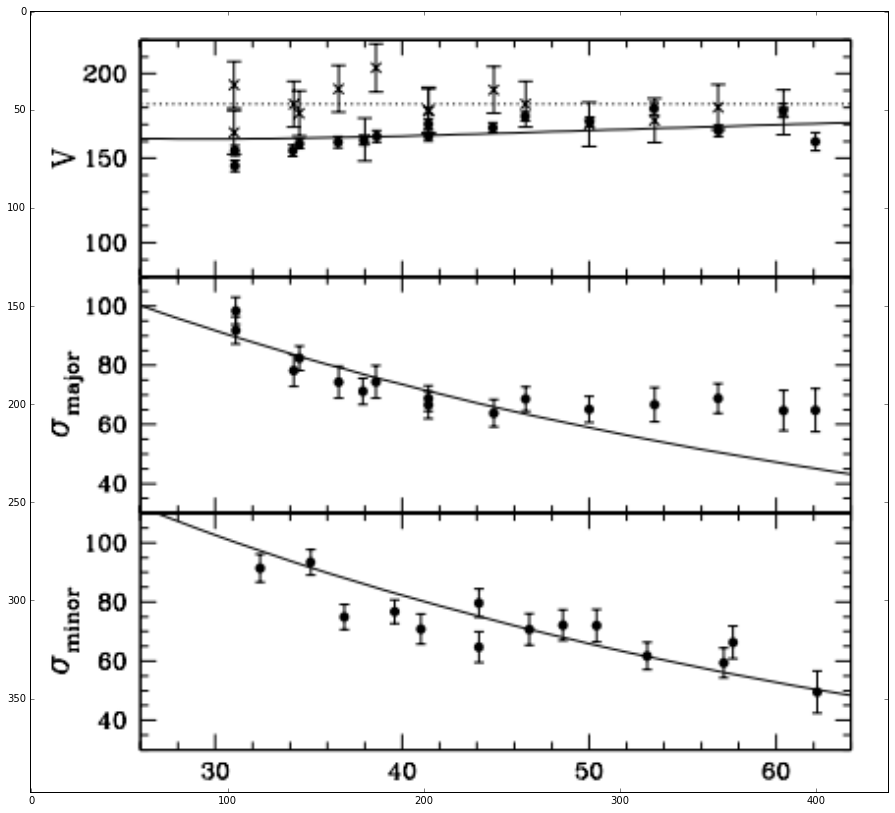

In [3]:
plt.imshow(np.asarray(Image.open("shapiro_fg4c.png")))
plt.plot()

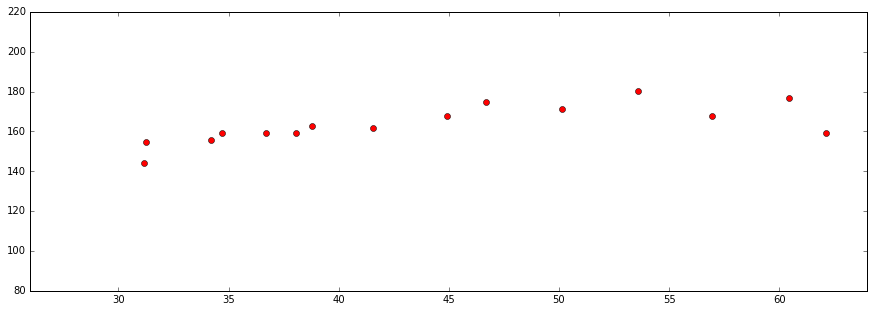

In [4]:
pylab.rcParams['figure.figsize'] = 15, 5

#Velocity
lu = (55, 15)
lu_val = (26, 220)
rd = (417, 135)
rd_val = (64, 80)

data = [(105,71), (104,80), (133,70), (138,67), (157,67), (170,67), (177,64), (203,65), 
        (235,60), (252,54), (285,57), (318,49), (350,60), (383,52), (399,67)]

def extend_values(data, lu, lu_val, rd, rd_val):
    xscale = 1.0*(rd_val[0]-lu_val[0])/(rd[0]-lu[0])
    yscale = 1.0*(rd_val[1]-lu_val[1])/(lu[1]-rd[1])
    extended = []
    for d in data:
        extended.append((xscale*(d[0]-lu[0])+lu_val[0], yscale*(rd[1] - d[1])+rd_val[1]))
    return extended
        
e_data = extend_values(data, lu, lu_val, rd, rd_val)
plt.plot(zip(*e_data)[0],zip(*e_data)[1], 'or')

vel_fit = lambda l: 283.*np.power(l, 0)
plt.plot(np.linspace(30., 90., 100), map(vel_fit, np.linspace(30., 90., 100)), '--')
plt.ylim(80, 220)
plt.xlim(26, 64)
plt.show()

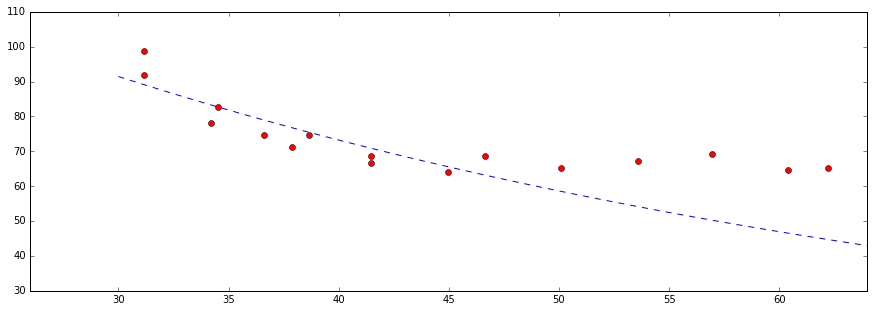

In [5]:
#Sig_maj
lu = (56, 136)
lu_val = (26, 110)
rd = (417, 256)
rd_val = (64, 30)

data = [(105,153), (105,163), (134,184), (137,177), (157,189), 
        (169,194), (176,189), (203,198), (203,201), (236,205), (252,198), (285,203), (318,200), (350,197), (383,204), (400,203)]

sig_maj_data = extend_values(data, lu, lu_val, rd, rd_val)
plt.plot(zip(*sig_maj_data)[0],zip(*sig_maj_data)[1], 'or')

sigR = lambda l: 197.*np.exp(-l/45.)
sigZ = lambda l: 201.*np.exp(-l/45.)
phi_to_R = lambda l: 0.5*(1 - 0.)
sig_maj = lambda l: sqrt(sigR(l)**2 * (phi_to_R(l) * sin_i2 + sigZ(l)**2 * cos_i2/sigR(l)**2))

plt.plot(np.linspace(30., 90., 100), map(sig_maj, np.linspace(30., 90., 100)), '--')
plt.ylim(30, 110)
plt.xlim(26, 64)
plt.show()

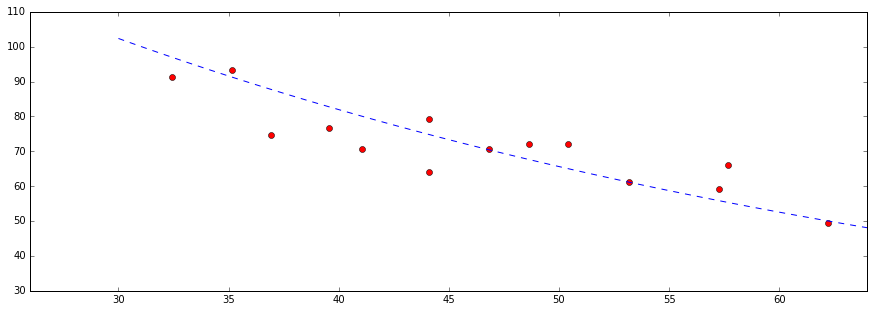

In [6]:
#Sig_min
lu = (56, 256)
lu_val = (26, 110)
rd = (417, 376)
rd_val = (64, 30)

data = [(117,284), (143,281), (160,309), (185,306), (199,315), (228,325), (228,302), (254,315), (271,313), (288,313), 
        (314,329), (353,332), (357,322), (400,347)]

sig_min_data = extend_values(data, lu, lu_val, rd, rd_val)
plt.plot(zip(*sig_min_data)[0], zip(*sig_min_data)[1], 'or')

sig_min = lambda l: sqrt(sigR(l)**2 * sin_i2 + sigZ(l)**2 * cos_i2)

plt.plot(np.linspace(30., 90., 100), map(sig_min, np.linspace(30., 90., 100)), '--')
plt.ylim(30, 110)
plt.xlim(26, 64)
plt.show()

In [7]:
h_kin = 45.
beta = 0.

def sig_maj_exp(R):
    global alpha, sig_R_0, h_kin, beta
    return np.exp(-R/h_kin)*sig_R_0*sqrt(0.5*(1 - beta) * sin_i2 + alpha**2 * cos_i2)

def sig_min_exp(R):
    global alpha, sig_R_0, h_kin
    return np.exp(-R/h_kin)*sig_R_0*sqrt(sin_i2 + alpha**2 * cos_i2)

def calc_chi2_normal(obs, obserr, predicted):
    return sum([(o-p)**2/err**2 for (o,p,err) in zip(obs, predicted, obserr)])/(len(obs))

alphas = np.arange(0.25, 1., 0.01)
sigmas = np.arange(80.0, 400, 0.25)

def compute_chi2_maps(alph=(), sigm=()):
    '''Вычисляем все изображения, чтобы потом только настройки менять'''
    image_min = np.random.uniform(size=(len(sigm), len(alph)))
    image_maj = np.random.uniform(size=(len(sigm), len(alph)))
    image = np.random.uniform(size=(len(sigmas), len(alphas)))
    for i,si in enumerate(sigm):
        for j,al in enumerate(alph):
            global alpha, sig_R_0
            alpha = al
            sig_R_0 = si
            sqerr_maj = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data)
            sqerr_min = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data)
            image_maj[i][j] = sqerr_maj
            image_min[i][j] = sqerr_min
    return image_maj, image_min

pics_path = "C:\\science\\2FInstability\\data\\ngc2775\\"
if not os.path.exists(pics_path):
    os.makedirs(pics_path)
if os.path.isfile(pics_path + 'chi2_map_maj.npy'):
    image_maj = np.load(pics_path + "chi2_map_maj.npy")
    image_min = np.load(pics_path + "chi2_map_min.npy")
else:
    image_maj, image_min = compute_chi2_maps(alph=alphas, sigm=sigmas)
    np.save(pics_path + 'chi2_map_maj', image_maj)
    np.save(pics_path + 'chi2_map_min', image_min)

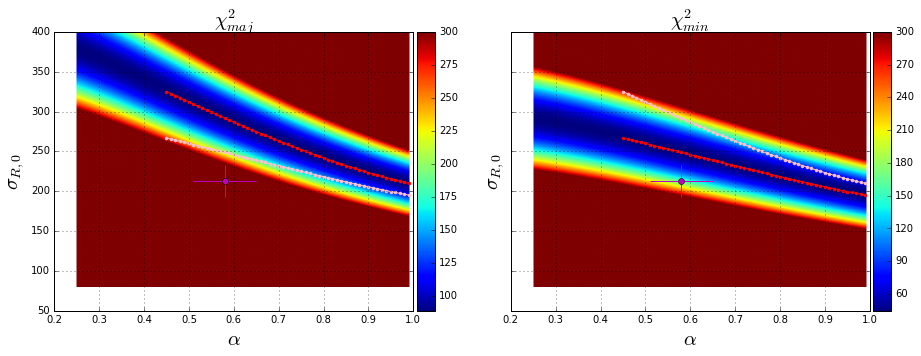

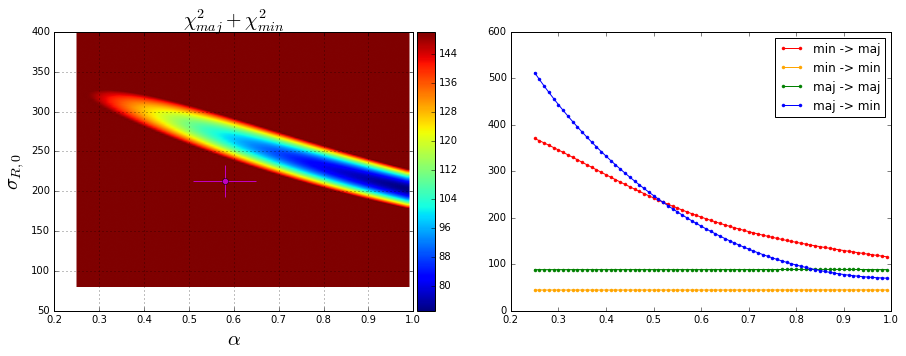

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_chi2_map(image, ax, log_scale=False, title='$\chi^2$', is_contour=False, vmax=0.):
    if image is not None:
        im = ax.imshow(image, cmap='jet', vmin=image.min(), vmax=vmax, interpolation='spline16', 
                   origin="lower", extent=[alphas[0], alphas[-1],sigmas[0],sigmas[-1]], aspect="auto")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        ax.set_title(title, size=20.)
        ax.set_ylabel('$\sigma_{R,0}$', size=20.)
        ax.set_xlabel(r'$\alpha$', size=20.)
        ax.grid(True)
        
min_sigmas = np.where(image_min < image_min.min() + 10.)
slice_alph, slice_sig = min_sigmas[1], min_sigmas[0]
slice_alph = map(lambda l: alphas[0] + (alphas[-1] - alphas[0])*l/len(image_min[0]) , slice_alph)
slice_sig = map(lambda l: sigmas[0] + (sigmas[-1] - sigmas[0])*l/len(image_min), slice_sig)
poly_slice_min = poly1d(polyfit(slice_alph, slice_sig, deg=3))
maj_sigmas = np.where(image_maj < image_maj.min() + 10.)
slice_alph, slice_sig = maj_sigmas[1], maj_sigmas[0]
slice_alph = map(lambda l: alphas[0] + (alphas[-1] - alphas[0])*l/len(image_maj[0]) , slice_alph)
slice_sig = map(lambda l: sigmas[0] + (sigmas[-1] - sigmas[0])*l/len(image_maj), slice_sig)
poly_slice_maj = poly1d(polyfit(slice_alph, slice_sig, deg=3))
       
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=[15,5])
plot_chi2_map(image_maj, axes[0], log_scale=False, title='$\chi^2_{maj}$', is_contour=False, vmax=300.)
plot_chi2_map(image_min, axes[1], log_scale=False, title='$\chi^2_{min}$', is_contour=False, vmax=300.)
axes[0].plot(0.58, 213., 'o', color='m')
axes[0].errorbar(0.58, 213., xerr=0.07, yerr=20., fmt='.', marker='.', mew=0, color='m')
axes[0].plot(alphas[20:], map(poly_slice_maj, alphas[20:]), '.-', label = 'maj -> maj', color= 'red')
axes[0].plot(alphas[20:], map(poly_slice_min, alphas[20:]), '.-', label = 'min -> maj', color= 'pink')
axes[1].plot(0.58, 213., 'o', color='m')
axes[1].errorbar(0.58, 213., xerr=0.07, yerr=20., fmt='.', marker='.', mew=0, color='m')
axes[1].plot(alphas[20:], map(poly_slice_min, alphas[20:]), '.-', label = 'min -> min', color='red')
axes[1].plot(alphas[20:], map(poly_slice_maj, alphas[20:]), '.-', label = 'maj -> min', color='pink') 
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=[15,5])
plot_chi2_map((image_min + image_maj)/2, axes[0], log_scale=False, title='$\chi^2_{maj}+\chi^2_{min}$', is_contour=False, vmax=150.)
axes[0].plot(0.58, 213., 'o', color='m')
axes[0].errorbar(0.58, 213., xerr=0.07, yerr=20., fmt='.', marker='.', mew=0, color='m')

err_maj_1, err_maj_2 = [], []
err_min_1, err_min_2 = [], []
for al in alphas:
    global alpha, sig_R_0
    alpha = al
    sig_R_0 = poly_slice_min(alpha)
    err_maj_1.append(sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data))
    err_min_1.append(sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data))
    sig_R_0 = poly_slice_maj(alpha)
    err_maj_2.append(sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data))
    err_min_2.append(sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data))
    
axes[1].plot(alphas, err_maj_1, '.-', label = 'min -> maj', color= 'red')
axes[1].plot(alphas, err_min_1, '.-', label = 'min -> min', color='orange')
axes[1].plot(alphas, err_maj_2, '.-', label = 'maj -> maj', color= 'green')
axes[1].plot(alphas, err_min_2, '.-', label = 'maj -> min', color='blue') 
axes[1].legend()

plt.show()

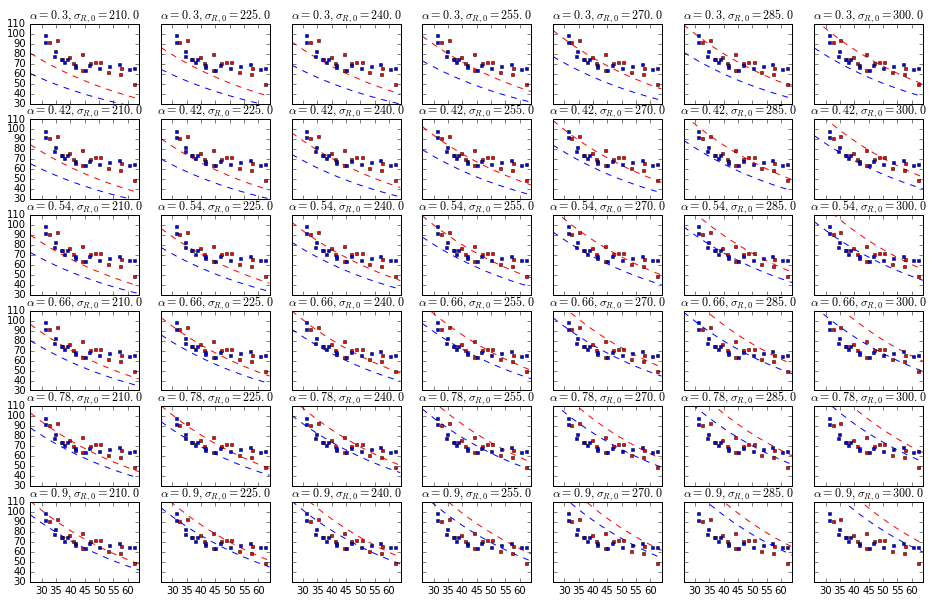

In [9]:
alphas = np.arange(0.3, 0.9, 0.12)
sigmas = np.arange(210., 310., 15.)
points = np.arange(26., 64., 0.1)
good_pics = []

def plot_ranges_gers(sigmas_range, alphas_range, good_pics=[], calc_chi=False, best_err=3):
    nrows = alphas.size
    ncols = sigmas.size
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=[16,10])
    plt_index = 0
    # Последнее - среднее геометрическое
    sqerr_majs, sqerr_mins, sqerr_mean = [],[],[]
    for al in alphas_range:
        for si in sigmas_range:
            global alpha, sig_R_0
            alpha = al
            sig_R_0 = si
            ax = axes[plt_index/ncols, plt_index % ncols]
            ax.set_title(r'$\alpha = %s, \sigma_{R,0}=%s$' % (al,si))
            
            sqerr_maj = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data)
            sqerr_min = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data)
            if sqerr_maj < 120. and sqerr_min < 120.:
                ax.plot(80., 105., 'og', ms = 10)
            
            ax.plot(points, [sig_maj_exp(R) for R in points], '--', color='blue')
            ax.plot(points, [sig_min_exp(R) for R in points], '--', color='red')
            ax.plot(zip(*sig_min_data)[0],zip(*sig_min_data)[1], 's', color='red', ms=3)
            ax.plot(zip(*sig_maj_data)[0],zip(*sig_maj_data)[1], 's', color='blue', ms=3)
            ax.set_ylim(30, 110)
            ax.set_xlim(26, 64)
            plt_index = plt_index + 1
    

plot_ranges_gers(sigmas, alphas, good_pics=good_pics, calc_chi=True)
plt.show()

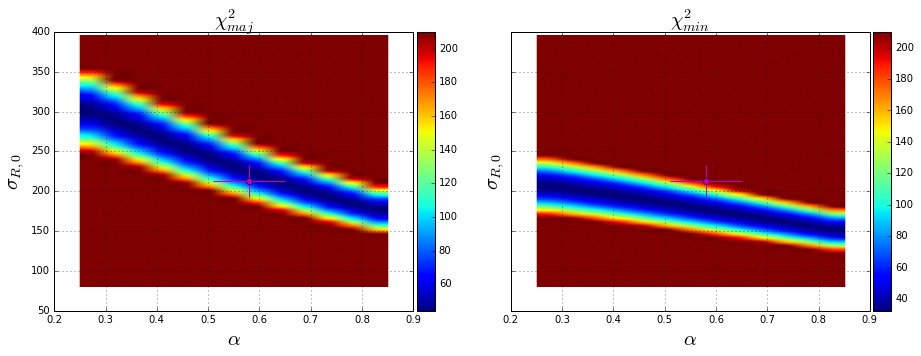

In [10]:
from IPython.html.widgets import *

def widget_plot_maps(h_k, b, vm, contour_swap):
    global alpha, sig_R_0, h_kin, beta, alphas, sigmas
    h_kin = h_k
    beta = b
    alphas = np.arange(0.25, 0.9, 0.05)
    sigmas = np.arange(80.0, 400, 5.)
    image_maj, image_min = compute_chi2_maps(alph=alphas, sigm=sigmas)    
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=[15,5])
    plot_chi2_map(image_maj, axes[0], log_scale=False, title='$\chi^2_{maj}$', is_contour=False, vmax=vm)
    plot_chi2_map(image_min, axes[1], log_scale=False, title='$\chi^2_{min}$', is_contour=False, vmax=vm)
    
    if contour_swap:
        norm = cm.colors.Normalize(vmax=image_min.max(), vmin=-image_min.max())
        cmap = cm.PRGn
        levels = np.linspace(start=image_min.min(), stop=vm, num=10)
        cset=axes[0].contour(image_min, levels, hold='on', colors = 'k', origin='lower', 
                             extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
        norm = cm.colors.Normalize(vmax=image_maj.max(), vmin=-image_maj.max())
        cmap = cm.PRGn
        levels = np.linspace(start=image_maj.min(), stop=vm, num=10)
        cset=axes[1].contour(image_maj, levels, hold='on', colors = 'k', origin='lower', 
                             extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
    
    axes[0].plot(0.58, 213., 'o', color='m')
    axes[0].errorbar(0.58, 213., xerr=0.07, yerr=20., fmt='.', marker='.', mew=0, color='m')
    axes[1].plot(0.58, 213., 'o', color='m')
    axes[1].errorbar(0.58, 213., xerr=0.07, yerr=20., fmt='.', marker='.', mew=0, color='m')
    plt.show()

interact(widget_plot_maps, h_k=(60, 80, 0.5), b=(0.15, 0.25, 0.01), vm = (70., 350., 10),  contour_swap=False);

#Выше был пример построения на основе данных Герсена и Шапиро и их аппроксимаций. Ниже попробуем использовать наш подход:

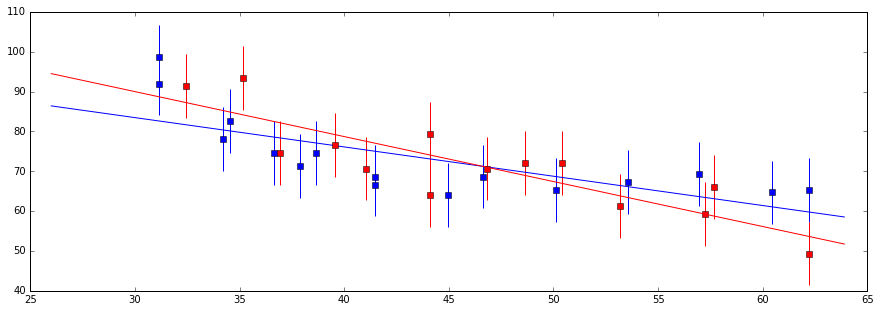

In [11]:
import scipy.interpolate as inter

radii_maj, sig_maj_p = zip(*sig_maj_data)
e_sig_maj_p = [8]*len(radii_maj)
spl_maj = inter.UnivariateSpline(radii_maj, sig_maj_p, k=1, s=10000)

radii_min, sig_min_p = zip(*sig_min_data)
e_sig_min_p = [8]*len(radii_min)
spl_min = inter.UnivariateSpline(radii_min, sig_min_p, k=1, s=10000)

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, spl_maj(points), label = '$\sigma_{los}^{maj}\, splinefit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, spl_min(points), label = '$\sigma_{los}^{min}\, splinefit$', color='red')

plt.show()

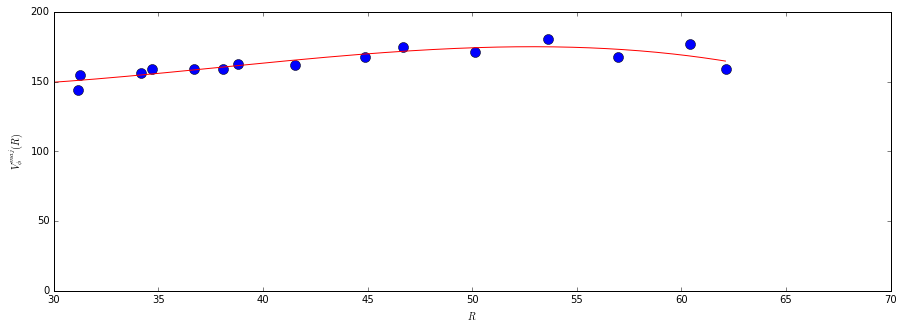

In [12]:
from numpy import poly1d, polyfit, power

r_ma_b, vel_ma_b = zip(*e_data)
poly_star = poly1d(polyfit(r_ma_b, vel_ma_b, deg=3))

plt.plot(r_ma_b, vel_ma_b, 'o', color='blue', markersize=10)
test_points = np.arange(0.0, max(r_ma_b), 0.1)
plt.plot(test_points, poly_star(test_points), '-', color='red')
plt.xlabel('$R$')
plt.ylim(0, 200)
plt.xlim(30, 70)
plt.ylabel('$V^{maj}_{\phi}(R)$')
plt.show()

C:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


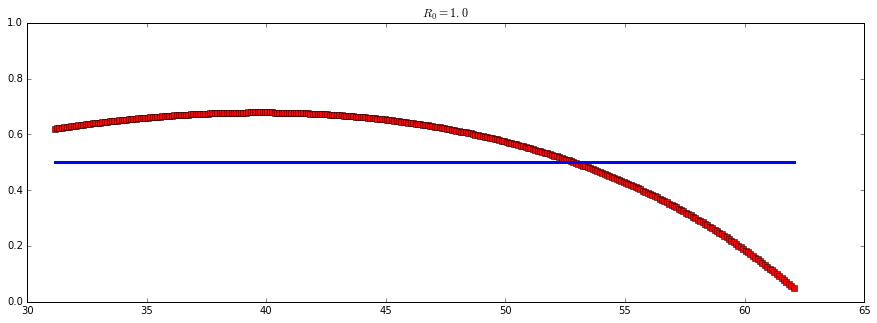

In [13]:
def sigPhi_to_sigR_real(R):
        return 0.5 * (1 + R*poly_star.deriv()(R) / poly_star(R))

test_points = np.arange(min(r_ma_b), max(r_ma_b), 0.1)

def f(R, Ro):
    return 0.5*(1 + np.exp( -R/Ro ))

xdata = test_points
ydata = sigPhi_to_sigR_real(xdata)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, xdata, ydata, p0=[1.0])
Ro = popt[0]

plt.plot(xdata, ydata, 's', color='r')
plt.plot(xdata, [f(p, Ro) for p in xdata], '-', linewidth=3.0, color='b')
# plt.axhline(y=0.5)
plt.axhline(y=0.0)
plt.title('$R_{0} = %s $' % Ro)
plt.ylim(0, 1)
plt.show()

def sigPhi_to_sigR(R):
    return sqrt(f(R, Ro))

In [14]:
#Значение sig_los_min в cutted
sig_min_0 = spl_min(radii_min[0])

#Значение sig_R в cutted
sig_R_0 = 80.
alpha = 0.3

def sigR_exp(R):
    return sig_R_0*spl_min(R)/sig_min_0

def sigZ_exp(R):
    return alpha * sigR_exp(R)

def sigPhi_exp(R):
    return sigPhi_to_sigR(R) * sigR_exp(R)

def sig_maj_exp(R):
    return sqrt(sigPhi_exp(R)**2 * sin(incl*pi/180)**2 + sigZ_exp(R)**2 * cos(incl*pi/180)**2)

def sig_min_exp(R):
    return sqrt(sigR_exp(R)**2 * sin(incl*pi/180)**2 + sigZ_exp(R)**2 * cos(incl*pi/180)**2)

cos_i, sin_i = cos(incl * pi / 180), sin(incl * pi / 180)

def sig_maj_exp(R):
    return sig_R_0*spl_min(R)/sig_min_0 * sqrt(sigPhi_to_sigR_real(R) * sin_i**2 + alpha**2 * cos_i**2)
#     return sig_R_0*spl_min(R)/sig_min_0 * sqrt(sigPhi_to_sigR(R) * sin_i**2 + alpha**2 * cos_i**2)
#     return sqrt(sigPhi_exp(R)**2 * sin(incl*pi/180)**2 + sigZ_exp(R)**2 * cos(incl*pi/180)**2)

def sig_min_exp(R):
    return sig_R_0*spl_min(R)/sig_min_0 * sqrt(sin_i**2 + alpha**2 * cos_i**2)
#     return sqrt(sigR_exp(R)**2 * sin(incl*pi/180)**2 + sigZ_exp(R)**2 * cos(incl*pi/180)**2)

(26, 64)

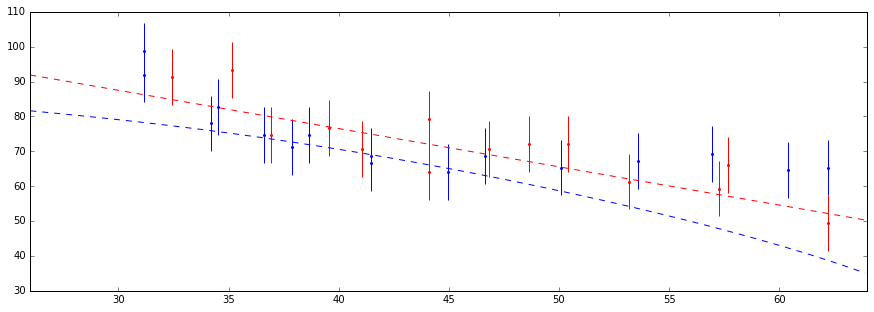

In [15]:
#Значение sig_R в cutted
sig_R_0 = 90.
alpha = 0.9

plt.plot(points, [sig_maj_exp(R) for R in points], '--', color='blue')
plt.plot(points, [sig_min_exp(R) for R in points], '--', color='red')

plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.ylim(30, 110)
plt.xlim(26, 64)

In [16]:
alphas = np.arange(0.25, 1.8, 0.01)
sigmas = np.arange(50.0, 200, 1.)

def calc_chi2_normal(obs, obserr, predicted):
    return sum([(o-p)**2/err**2 for (o,p,err) in zip(obs, predicted, obserr)])/(len(obs))

def compute_chi2_maps(alphas=(), sigmas=()):
    '''Вычисляем все изображения, чтобы потом только настройки менять'''
    image_min = np.random.uniform(size=(len(sigmas), len(alphas)))
    image_maj = np.random.uniform(size=(len(sigmas), len(alphas)))
    image = np.random.uniform(size=(len(sigmas), len(alphas)))
    for i,si in enumerate(sigmas):
        for j,al in enumerate(alphas):
            global alpha, sig_R_0
            alpha = al
            sig_R_0 = si
            sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
            sqerr_min = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(r) for r in radii_min])
            sqerr_sum = 0.5*sqerr_maj+0.5*sqerr_min
            image[i][j] = sqerr_sum
            image_maj[i][j] = sqerr_maj
            image_min[i][j] = sqerr_min
    return image, image_maj, image_min

image, image_maj, image_min = compute_chi2_maps(alphas=alphas, sigmas=sigmas)

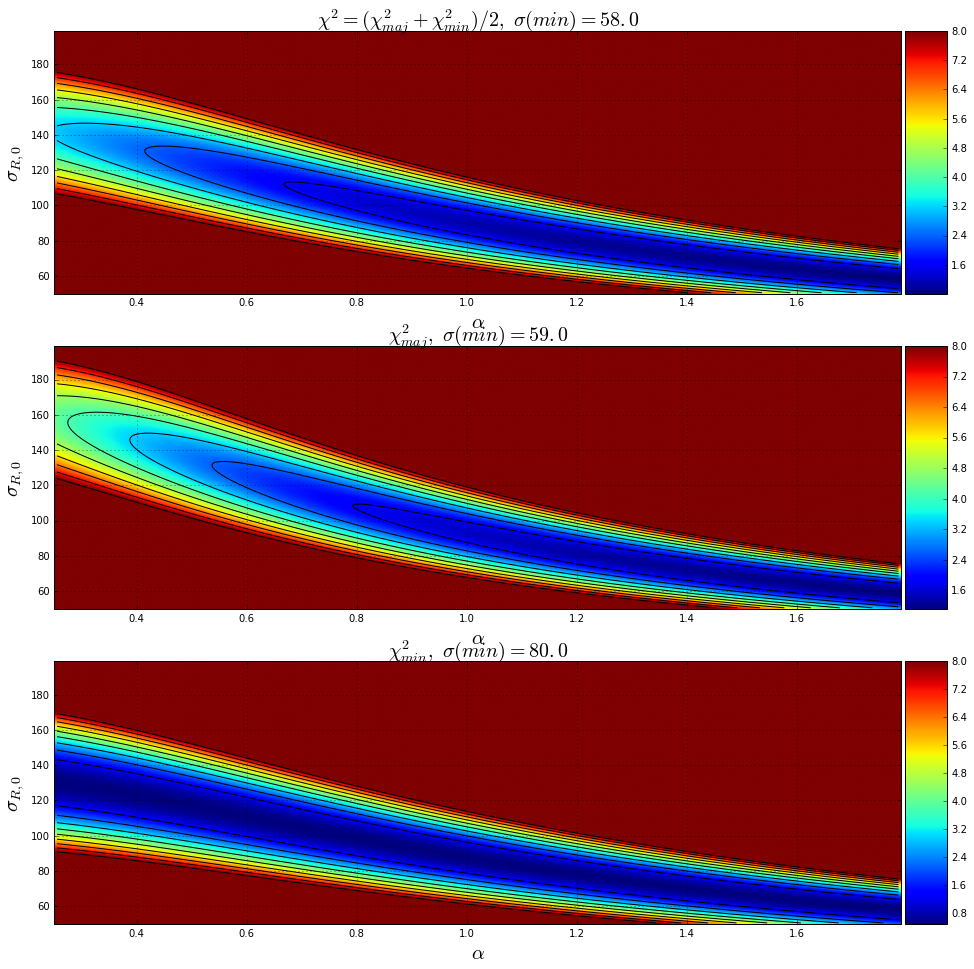

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm

def plot_chi2_map(image, ax, log_scale=False, title='$\chi^2$', is_contour=False, vmax=0.):
    if image is not None:
        if log_scale:
            image_log = np.apply_along_axis(np.log, 1, image)
            vmax = image_log.max()
        else:
            image_log = image
        if is_contour:
            norm = cm.colors.Normalize(vmax=image.max(), vmin=-image.max())
            cmap = cm.PRGn
            levels = np.linspace(start=image_log.min(), stop=vmax, num=10)
            cset=ax.contour(image_log, levels, hold='on', colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
        im = ax.imshow(image_log, cmap='jet', vmin=image_log.min(), vmax=vmax, interpolation='spline16', 
                   origin="lower", extent=[alphas[0], alphas[-1],sigmas[0],sigmas[-1]], aspect="auto")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        min_sigma = sigmas[int(np.where(image == image.min())[0])]        
        ax.set_title(title + '$,\ \sigma(min)=%s$' % min_sigma, size=20.)
        ax.set_ylabel('$\sigma_{R,0}$', size=20.)
        ax.set_xlabel(r'$\alpha$', size=20.)
        ax.grid(True)

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=True, figsize=[16,16])
plot_chi2_map(image, axes[0], log_scale=False, title='$\chi^2 = (\chi^2_{maj} + \chi^2_{min})/2$', is_contour=True, vmax=8.)
plot_chi2_map(image_maj, axes[1], log_scale=False, title='$\chi^2_{maj}$', is_contour=True, vmax=8.)
plot_chi2_map(image_min, axes[2], log_scale=False, title='$\chi^2_{min}$', is_contour=True, vmax=8.)
plt.show()

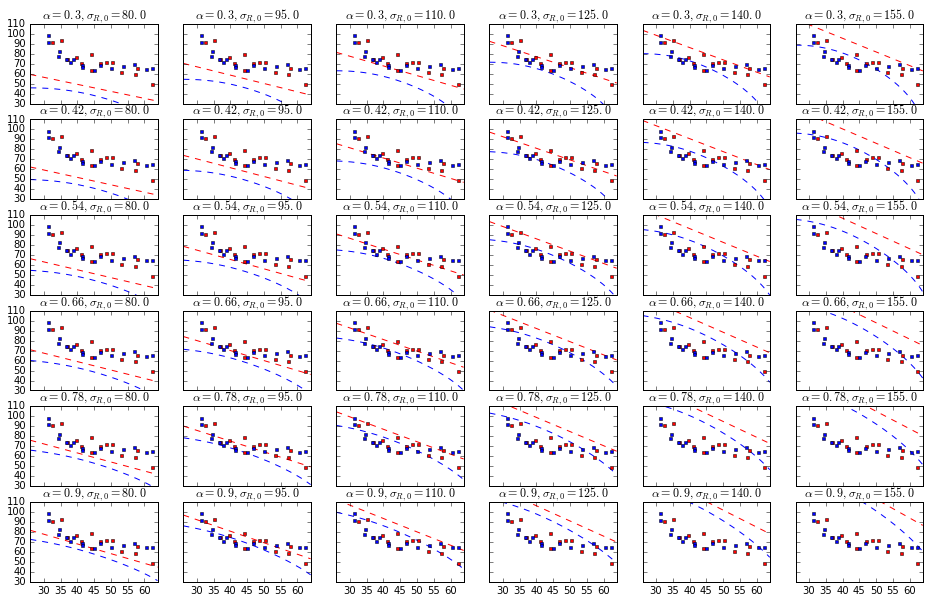

In [18]:
alphas = np.arange(0.3, 0.9, 0.12)
sigmas = np.arange(80., 160., 15.)
points = np.arange(26., 64., 0.1)
good_pics = []

plot_ranges_gers(sigmas, alphas, good_pics=good_pics, calc_chi=True)
plt.show()

In [19]:
tex_imgs_dir = "C:\\Users\\root\\Dropbox\\RotationCurves\\PhD\\paper1\\text\\imgs"
try: 
    os.chdir(tex_imgs_dir)
except:
    tex_imgs_dir = "C:\\Users\\Alex March\\Dropbox\\RotationCurves\\PhD\\paper1\\text\\imgs"

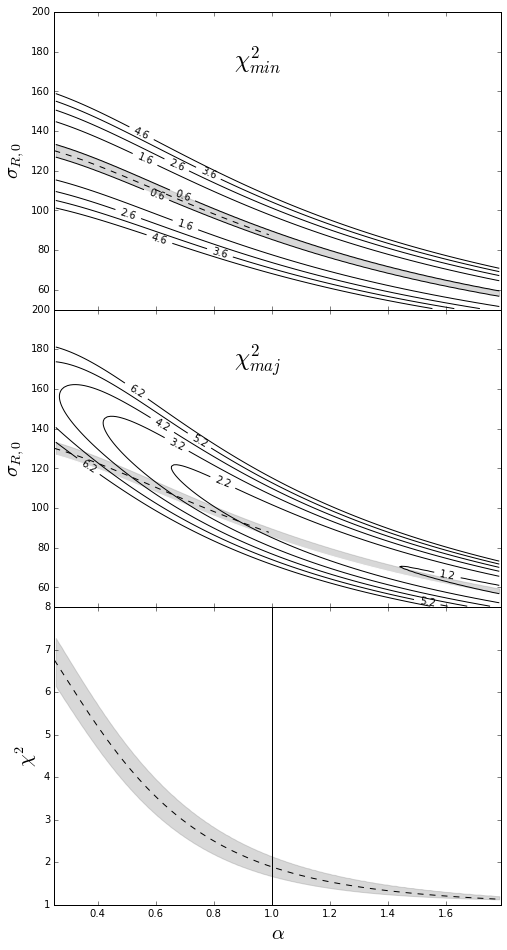

In [20]:
os.chdir(tex_imgs_dir)

alphas = np.arange(0.25, 1.8, 0.01)
sigmas = np.arange(50.0, 200, 1.)

cos_i, sin_i = cos(incl * pi / 180), sin(incl * pi / 180)
main_slice = lambda l: sig_min_0/sqrt(sin_i**2 + cos_i**2 * l**2)

import matplotlib.mlab as mlab
import matplotlib

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=[8,16])
ax = axes[0]
levels = np.linspace(start=image_min.min()*1.1, stop=image_min.min()*1.1+4, num=5)
cset=ax.contour(image_min, levels,  colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
min_map_gutter = cset.collections[0].get_paths()

v1,v2 = min_map_gutter[1].vertices, min_map_gutter[0].vertices
x1,x2 = v1[:,0], v2[:,0]
y1,y2 = v1[:,1], v2[:,1]
plt.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
ax.text(0.87, 172, '$\chi^2_{min}$', size = 24.)
ax.set_ylabel('$\sigma_{R,0}$', size=20.)
xx = np.arange(0.25, 1.0, 0.01)
ax.plot(xx, map(main_slice, xx), '--', color='black')
ax.set_ylim(50, 200)


min_sigmas = np.where(image_min < image_min.min() + 0.03)
slice_alph, slice_sig = min_sigmas[1], min_sigmas[0]
slice_alph = map(lambda l: alphas[0] + (alphas[-1] - alphas[0])*l/len(image_min[0]) , slice_alph)
slice_sig = map(lambda l: sigmas[0] + (sigmas[-1] - sigmas[0])*l/len(image_min), slice_sig)
# ax.plot(slice_alph, slice_sig, '.', color='pink')
poly_slice = poly1d(polyfit(slice_alph, slice_sig, deg=3))
# ax.plot(xx, poly_slice(xx), '.-', color='black')
ax.fill_between(x1, y1, 0, color='gray', alpha=0.3)
ax.fill_between(x2, y2, 0, color='white')

ax = axes[1]
levels = np.append(np.linspace(start=image_maj.min()+0.1, stop=image_maj.min()+4.1, num=6), np.array([image_maj.min()+0.25]))
levels = np.linspace(start=image_maj.min()*1.1, stop=image_maj.min()*1.1+5, num=6)
cset=ax.contour(image_maj, levels, hold='on', colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
plt.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
ax.text(0.87, 172, '$\chi^2_{maj}$', size = 24.)
ax.set_ylabel('$\sigma_{R,0}$', size=20.)
xx = np.arange(0.25, 1.0, 0.01)
ax.plot(xx, map(main_slice, xx), '--', color='black')

ax.fill_between(x1, y1, 0, color='gray', alpha=0.3)
ax.fill_between(x2, y2, 0, color='white')
ax.set_ylim(50, 200)

ax = axes[2]
err_maj = []
for al in alphas:
    global alpha, sig_R_0
    alpha = al
    sig_R_0 = main_slice(al)
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj.append(sqerr_maj)
ax.plot(alphas, err_maj, '--', color='black')
err_maj1 = []
for pa in zip(x2,y2):
    global alpha, sig_R_0
    alpha = pa[0]
    sig_R_0 = pa[1]
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj1.append(sqerr_maj)
# ax.plot(x2, err_maj1, '-', color='black')
err_maj2 = []
for pa in zip(x1,y1):
    global alpha, sig_R_0
    alpha = pa[0]
    sig_R_0 = pa[1]
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj2.append(sqerr_maj)
# ax.plot(x1, err_maj2, '-', color='black')
ax.set_ylabel(r'$\chi^2$', size=20.)
ax.set_xlabel(r'$\alpha$', size=20.)


import scipy.interpolate as sp
try:
    f1 = sp.interp1d(x2, err_maj1, kind='linear')
    ax.fill_between(x1, map(f1, x1), err_maj2, color='grey', alpha=0.3)
except Exception:
    f2 = sp.interp1d(x1, err_maj2, kind='linear')
    ax.fill_between(x2, map(f2, x2), err_maj1, color='grey', alpha=0.3)

ax.set_ylabel(r'$\chi^2$', size=20.)
ax.set_xlabel(r'$\alpha$', size=20.)
ax.axvline(x=1.0, color='black')

# ax.set_ylim(3., 3.8)


fig.subplots_adjust(hspace=0.)
axes[0].yaxis.get_major_ticks()[0].set_visible(False)
axes[1].yaxis.get_major_ticks()[0].set_visible(False)
ax.set_xlim(0.25, alphas[-1])

plt.savefig('ngc2775_maps.eps', format='eps')
plt.savefig('ngc2775_maps.png', format='png')
plt.savefig('ngc2775_maps.pdf', format='pdf', dpi=150)

plt.show()

os.chdir("C:\\science\\2FInstability\\data\\ngc2775")

In [21]:
import scipy.optimize as opt

def chisqfunc((x_sig, x_alpha)):
    global sig_R_0, alpha
    sig_R_0 = x_sig
    alpha = x_alpha
    sqerr_ma = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(l) for l in radii_maj])
    sqerr_mi = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(l) for l in radii_min])
#     print 'chisqf ', sqerr_mi*len(sig_min_p), sqerr_ma*len(sig_maj_p)
    chisq = (sqerr_mi*len(sig_min_p) + sqerr_ma*len(sig_maj_p)) / (len(sig_min_p) + len(sig_maj_p) - 2)
    return chisq

x0 = np.array([130., 0.7])

res = opt.minimize(chisqfunc, x0, bounds=[(sigmas[0], sigmas[-1]), (alphas[0], alphas[-1])], method='L-BFGS-B')
print res

      fun: 0.91388121952510259
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00316958, -0.30089813])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 93
      nit: 24
   status: 0
  success: True
        x: array([ 61.5508396 ,   1.66831286])


In [22]:
res.hess_inv(res.x)

array([ 352860.02289142,  -10150.19632863])

In [23]:
def gen_next_normal(radii, sig, esig):
    randomDelta =  np.array([np.random.normal(0., derr/2, 1)[0] for derr in esig] ) 
    randomdataY = sig + randomDelta
    return zip(radii, randomdataY)

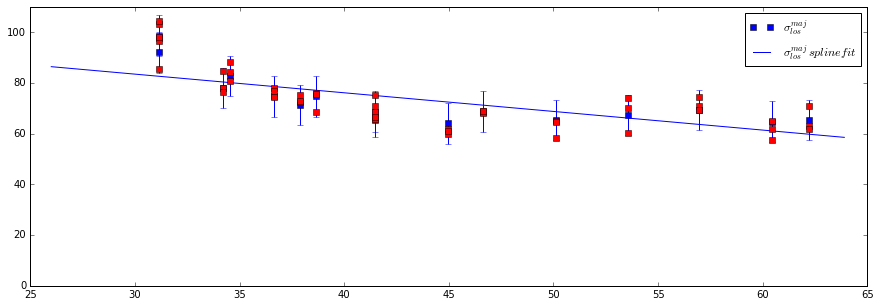

In [24]:
poly_sig_maj = spl_maj
poly_sig_min = spl_min

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='o', marker='.', color='blue')
plt.plot(points, poly_sig_maj(points), label = '$\sigma_{los}^{maj}\, splinefit$', color='blue')
 
for i in range(3):
    r, s = zip(*gen_next_normal(radii_maj, sig_maj_p, e_sig_maj_p))
    plt.plot(r, s, 's', color='red')

plt.ylim(0., 110.)
plt.legend()
plt.show()

--- 215.04700017 seconds ---


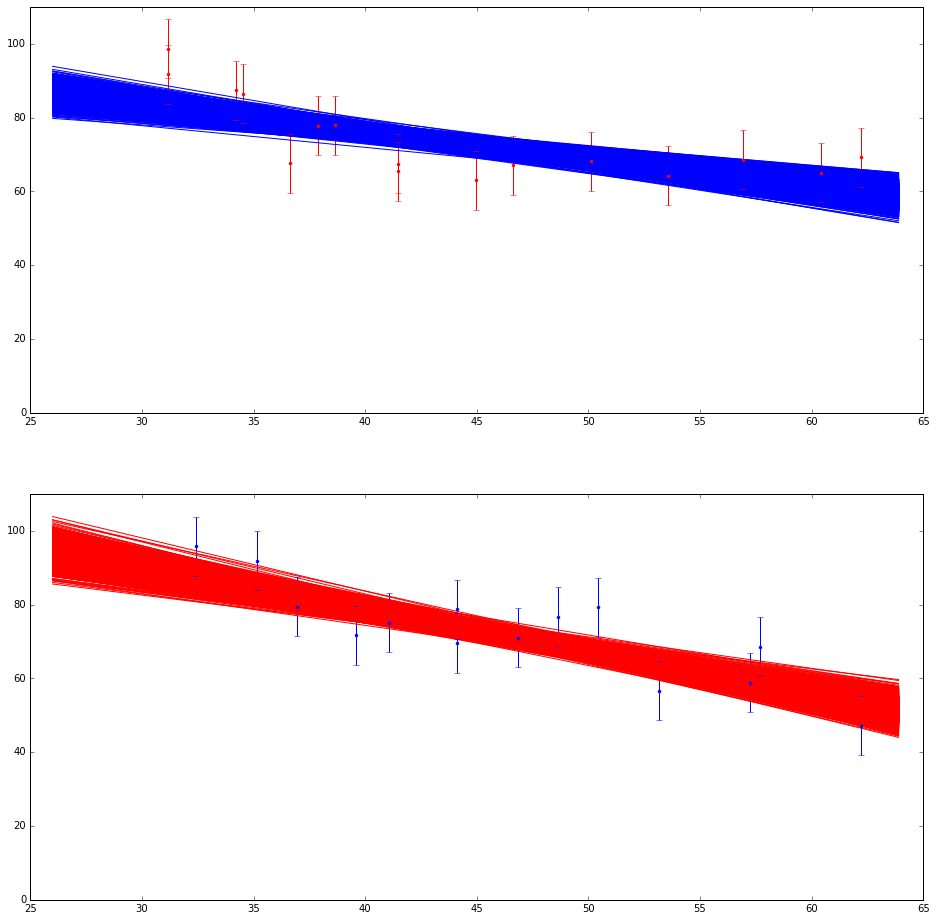

In [25]:
import time
# os.chdir("C:\\science\\2FInstability\\data\\ngc2275")

N = 2000

result = []
start_time = time.time()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))

radii_maj1, sig_maj_p1, e_sig_maj_p1 = radii_maj, sig_maj_p, e_sig_maj_p
radii_min1, sig_min_p1, e_sig_min_p1 = radii_min, sig_min_p, e_sig_min_p

for i in log_progress(range(N)):
    global spl_maj, spl_min
    global radii_min, radii_maj, sig_min_p, sig_maj_p, sig_min_0

    r, s = zip(*gen_next_normal(radii_maj1, sig_maj_p1, e_sig_maj_p1))
    spl_maj = inter.UnivariateSpline(r, s, k=1, s=10000.)

    radii_maj, sig_maj_p = r, s

    ax1.plot(points, spl_maj(points), label = '$\sigma_{los}^{maj}\, splinefit$', color='blue')

    r, s = zip(*gen_next_normal(radii_min1, sig_min_p1, e_sig_min_p1))
    spl_min = inter.UnivariateSpline(r, s, k=1, s=10000.)
    sig_min_0 = spl_min(radii_min[0])

    radii_min, sig_min_p = r, s

    ax2.plot(points, spl_min(points), label = '$\sigma_{los}^{maj}\, splinefit$', color='red')

    res = opt.minimize(chisqfunc, x0, bounds=[(sigmas[0], sigmas[-1]), (alphas[0], alphas[-1])], method='L-BFGS-B')
#         print res.fun
    result.append(res.x)
#     np.save(pics_path + 'monte_carlo', np.array(result))
print("--- %s seconds ---" % (time.time() - start_time))
    
ax1.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='o', marker='.', color='red')
ax2.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='o', marker='.', color='blue')    
ax1.set_ylim(0., 110.)
ax2.set_ylim(0., 110.)
plt.show()


radii_maj, sig_maj_p, e_sig_maj_p = radii_maj1, sig_maj_p1, e_sig_maj_p1
radii_min, sig_min_p, e_sig_min_p = radii_min1, sig_min_p1, e_sig_min_p1

In [26]:
len(result)

2000

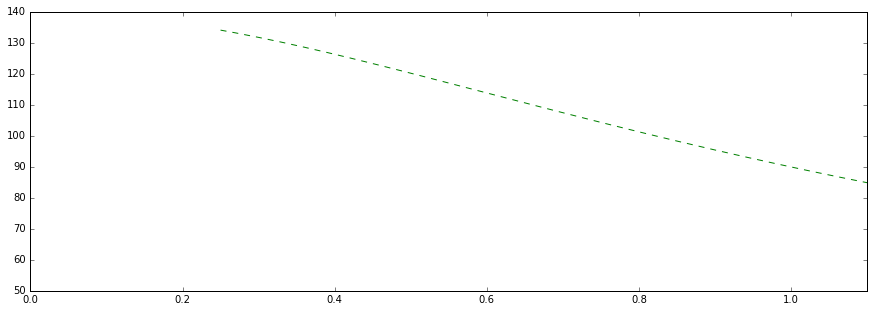

In [27]:
s,a = zip(*result)
plt.plot(a, s, '.')
plt.plot(alphas, map(main_slice, alphas), '--')
plt.xlim(0.0, 1.1)
# plt.ylim(100, 140)
plt.show()

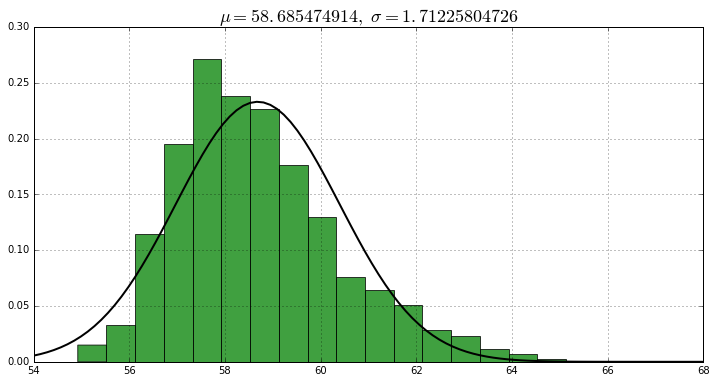

In [28]:
from scipy.stats import norm

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(s, 20, normed=1, facecolor='green', alpha=0.75)
mu, std = norm.fit(s)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

ax.set_title('$\mu=%s,\ \sigma=%s$' % (mu, std), fontsize=18)
ax.grid(True)

plt.show()

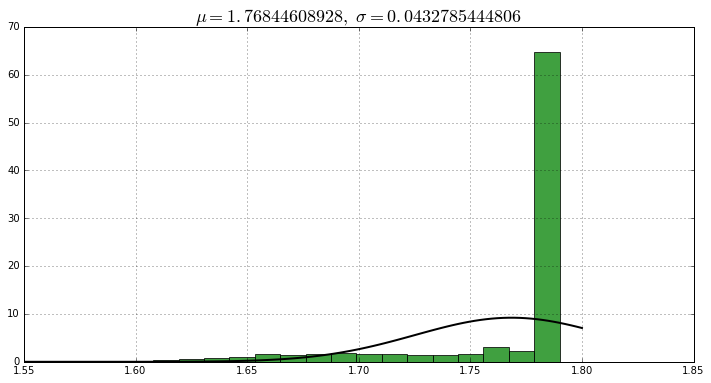

In [29]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(a, 20, normed=1, facecolor='green', alpha=0.75)
mu, std = norm.fit(a)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

ax.set_title('$\mu=%s,\ \sigma=%s$' % (mu, std), fontsize=18)
ax.grid(True)

plt.show()

NLLC Marquardt-Levenberg

In [30]:
def calc_chi2_normal(obs, obserr, predicted):
    return sum([(o-p)**2/err**2 for (o,p,err) in zip(obs, predicted, obserr)])/len(obs)

def chisqfunc1((x_sig, x_alpha)):
    global sig_R_0, alpha
    sig_R_0 = x_sig
    alpha = x_alpha
    sqerr_ma = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    return sqerr_ma

def chisqfunc2((x_sig, x_alpha)):
    global sig_R_0, alpha
    sig_R_0 = x_sig
    alpha = x_alpha
    sqerr_mi = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(r) for r in radii_min])
    return sqerr_mi

def func((x_sig, x_alpha)):
    return [chisqfunc1((x_sig, x_alpha)), chisqfunc2((x_sig, x_alpha))]

In [31]:
res = opt.root(func, [110., 0.5], method='lm')
res

   cov_x: None
    fjac: array([[ 1.12085698,  0.00182164],
       [ 0.03286687, -0.00948255]])
     fun: array([ 1.23161062,  0.51709338])
    ipvt: array([2, 1])
 message: 'Number of calls to function has reached maxfev = 600.'
    nfev: 601
     qtf: array([-0.14969524, -1.32768366])
  status: 5
 success: False
       x: array([ 61.58870709,   1.68857781])

In [32]:
# np.dot(res.cov_x, res.fun)

In [33]:
# s_sq = (np.array(func(res.x))**2).sum()/(len(sig_maj_p)+len(sig_min_p)-2)
# pcov = res.cov_x * s_sq
# pcov

In [34]:
x, cox = opt.leastsq(func, [110., 0.5])
x, cox

C:\Anaconda\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 600.
  warnings.warn(errors[info][0], RuntimeWarning)


(array([ 61.58870709,   1.68857781]), 5)

In [35]:
def func(x, a, b, c):
    return [a * np.exp(l) if l > 2.0 else b*l+c for l in x]
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)


In [36]:
popt, pcov = opt.curve_fit(func, xdata, y)
popt, pcov

(array([ 2.5,  1.3,  0.5]), array([[ 0.,  0., -0.],
        [ 0.,  0., -0.],
        [ 0., -0.,  0.]]))

In [37]:
min_n = len(radii_maj)

def func(x, alph, sig):
    global alpha, sig_R_0
    alpha = alph
    sig_R_0 = sig
    return [sig_min_exp(x[l]) if l > min_n else sig_maj_exp(x[l]) for l in range(len(x))]

In [38]:
rr = radii_maj + radii_min
print len(rr), min_n
sgs = sig_maj_p + sig_min_p
esgs = e_sig_maj_p + e_sig_min_p
esgs = [l/2 for l in esgs]

30 16


In [39]:
sig_min_0 = spl_min(radii_min[0]) 
popt, pcov = opt.curve_fit(func, rr, sgs, sigma=esgs, absolute_sigma=True)
print popt, pcov

s_sq = np.array([((np.array(func(rr, popt[0], popt[1]))-np.array(sgs))**2)[l]/esgs[l]**2 for l 
                 in range(len(rr))]).sum()/(len(rr)-2)
pcov = pcov * s_sq
for i in range(len(pcov)):
    print sqrt(pcov[i][i])

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

In [ ]:
def err_pcov(popt, pcov):
    s_sq = np.array([((np.array(func(rr, popt[0], popt[1]))-np.array(sgs))**2)[l]
                     /esgs[l]**2 for l in range(len(rr))]).sum()/(len(rr)-2)
    pcov = pcov * s_sq
    return (sqrt(pcov[0][0]), sqrt(pcov[1][1]))

In [ ]:
import time
os.chdir("C:\\science\\2FInstability\\data\\ngc2275")

N = 100

result1 = []
start_time = time.time()

for i in log_progress(range(N)):
    global spl_maj, spl_min
    r, s = zip(*gen_next_normal(radii_maj, sig_maj_p, e_sig_maj_p))
    r1, s1 = zip(*gen_next_normal(radii_min, sig_min_p, e_sig_min_p))
    rr = r + r1
    sgs = s + s1
    
    global sig_min_0
    spl_min = inter.UnivariateSpline(r1[1:], s1[1:], k=3, s=10000.)
    sig_min_0 = spl_min(radii_min[0])
    
    
#     popt, pcov = opt.curve_fit(func, radii_maj+radii_min, sig_maj_p+sig_min_p, 
#                                sigma=e_sig_maj_p+e_sig_min_p, absolute_sigma=True)
    popt, pcov = opt.curve_fit(func, rr, sgs, sigma=e_sig_maj_p+e_sig_min_p, absolute_sigma=True)

    err = err_pcov(popt, pcov)
    result1.append((popt[0], popt[1], err[0], err[1]))
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
a,s,erra,errs = zip(*result1)
# plt.plot(a, s, '.')
plt.errorbar(a, s, yerr=errs, xerr=erra, fmt='o', marker='.', color='red')
plt.plot(alphas, map(main_slice, alphas), '--')
plt.xlim(0.0, 0.99)
plt.ylim(0, 250)
plt.show()

In [ ]:
plt.errorbar(a, s, yerr=errs, fmt='o', marker='.', color='red')
plt.plot(alphas, map(main_slice, alphas), '--')
plt.xlim(0.0, 0.99)
plt.ylim(0, 250)
plt.show()

In [ ]:
# def chi_last(r, s, es, alph, sig):
#     df = func(r, alph, sig)-np.array(s)
#     qf = [df[l]/es[l] for l in range(len(r))]
#     qf = [l**2 for l in qf]
#     print sum(qf[min_n:]), sum(qf[:min_n]) 
#     return sum(qf)/(len(r)-2)

# N = 2
# for i in range(N):
#     global spl_maj, spl_min
#     global alpha, sig_R_0
#     r, s = zip(*gen_next_normal(radii_maj, sig_maj_p, e_sig_maj_p))
#     spl_maj = inter.UnivariateSpline(r[1:], s[1:], k=3, s=10000.)
#     r1, s1 = zip(*gen_next_normal(radii_min, sig_min_p, e_sig_min_p))
#     spl_min = inter.UnivariateSpline(r1[1:], s1[1:], k=3, s=10000.)
    
#     global sig_min_0
#     sig_min_0 = spl_min(radii_min[0])
    
#     rr = r + r1
#     sgs = s + s1
#     res = opt.minimize(chisqfunc, x0, bounds=[(sigmas[0], sigmas[-1]), (alphas[0], alphas[-1])], method='L-BFGS-B')
#     popt, pcov = opt.curve_fit(func, rr, sgs, sigma=esgs, absolute_sigma=True)
#     print res.x, popt
# #     print chisqfunc(res.x), chisqfunc((popt[1], popt[0]))
#     s_fs = np.array([((np.array(func(rr, res.x[1], res.x[0]))-np.array(sgs))**2)[l]
#                      /esgs[l]**2 for l in range(len(rr))]).sum()/(len(rr)-2)
#     s_ps = np.array([((np.array(func(rr, popt[0], popt[1]))-np.array(sgs))**2)[l]
#                      /esgs[l]**2 for l in range(len(rr))]).sum()/(len(rr)-2)
#     print s_fs, s_ps
# #     print chisqfunc1(res.x), chisqfunc1((popt[1], popt[0]))
# #     print chisqfunc2(res.x), chisqfunc2((popt[1], popt[0]))
# #     print chi_last(rr, sgs, esgs, res.x[1], res.x[0]), chi_last(rr, sgs, esgs, popt[0], popt[1])
#     alpha = res.x[1]
#     sig_R_0 = res.x[0]
#     sqerr_ma = calc_chi2_normal(s, e_sig_maj_p, [sig_maj_exp(l) for l in r])
#     sqerr_mi = calc_chi2_normal(s1, e_sig_min_p, [sig_min_exp(l) for l in r1])
#     chisqs = (sqerr_mi*len(sig_min_p) + sqerr_ma*len(sig_maj_p)) / (len(sig_min_p) + len(sig_maj_p))
#     print sqerr_ma, sqerr_mi, chisqs
#     alpha = popt[0]
#     sig_R_0 = popt[1]
#     sqerr_ma1 = calc_chi2_normal(s, e_sig_maj_p, [sig_maj_exp(l) for l in r])
#     sqerr_mi1 = calc_chi2_normal(s1, e_sig_min_p, [sig_min_exp(l) for l in r1])
#     chisqs1 = (sqerr_mi1*len(sig_min_p) + sqerr_ma1*len(sig_maj_p)) / (len(sig_min_p) + len(sig_maj_p))
#     vcom = lambda l: 'v' if l[0] > l[1] else '^'
#     print vcom((sqerr_ma,sqerr_ma1)), vcom((sqerr_mi,sqerr_mi1)), vcom((chisqs, chisqs1))
#     print sqerr_ma1, sqerr_mi1, chisqs1
    
 
#     alpha = res.x[1]
#     sig_R_0 = res.x[0]
#     sqerr_ma = chi_last(r, s, e_sig_maj_p, alpha, sig_R_0)
#     sqerr_mi = chi_last(r1, s1, e_sig_min_p, alpha, sig_R_0)
#     chisqs = (sqerr_mi*len(sig_min_p) + sqerr_ma*len(sig_maj_p)) / (len(sig_min_p) + len(sig_maj_p))
#     print sqerr_ma, sqerr_mi, chisqs
#     alpha = popt[0]
#     sig_R_0 = popt[1]
#     sqerr_ma1 = chi_last(r, s, e_sig_maj_p, alpha, sig_R_0)
#     sqerr_mi1 = chi_last(r1, s1, e_sig_min_p, alpha, sig_R_0)
#     chisqs1 = (sqerr_mi1*len(sig_min_p) + sqerr_ma1*len(sig_maj_p)) / (len(sig_min_p) + len(sig_maj_p))
#     vcom = lambda l: 'v' if l[0] > l[1] else '^'
#     print vcom((sqerr_ma,sqerr_ma1)), vcom((sqerr_mi,sqerr_mi1)), vcom((chisqs, chisqs1))
#     print sqerr_ma1, sqerr_mi1, chisqs1
    
    
#     print '-'*20
# #     print calc_chi2_normal(s, e_sig_maj_p, [sig_maj_exp(l) for l in r])*len(s)/(len(s)-2), chi_last(r, s, e_sig_maj_p, alpha, sig_R_0)
# #     print calc_chi2_normal(s1, e_sig_min_p, [sig_min_exp(l) for l in r1])*len(s1)/(len(s1)-2), chi_last(r1, s1, e_sig_min_p, alpha, sig_R_0)
# #     print func(r, alpha, sig_R_0), [sig_maj_exp(l) for l in r]
#     print chisqfunc((sig_R_0, alpha)), chi_last(radii_maj+radii_min, sig_maj_p+sig_min_p, 
#                                e_sig_maj_p+e_sig_min_p, alpha, sig_R_0)
    

# #     sqerr_ma = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
# #     sqerr_mi = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(r) for r in radii_min])
# #     print 'chisqf ', sqerr_mi*len(sig_min_p) + sqerr_ma*len(sig_maj_p)
# #     chisq = (sqerr_mi*len(sig_min_p) + sqerr_ma*len(sig_maj_p)) / (len(sig_min_p) + len(sig_maj_p) - 2)
    
    
#     print '-'*20

In [ ]:
radii_maj, sig_maj_p, e_sig_maj_p = radii_maj1, sig_maj_p1, e_sig_maj_p1
radii_min, sig_min_p, e_sig_min_p = radii_min1, sig_min_p1, e_sig_min_p1

N = 2
for i in range(N):
    global spl_maj, spl_min
    global radii_min, radii_maj, sig_min_p, sig_maj_p
    
    r, s = zip(*gen_next_normal(radii_maj, sig_maj_p, e_sig_maj_p))
    spl_maj = inter.UnivariateSpline(r[1:], s[1:], k=3, s=10000.)
    r1, s1 = zip(*gen_next_normal(radii_min, sig_min_p, e_sig_min_p))
    spl_min = inter.UnivariateSpline(r1[1:], s1[1:], k=3, s=10000.)
    
    global sig_min_0
    sig_min_0 = spl_min(radii_min[0])
    
    radii_maj, sig_maj_p = r, s
    radii_min, sig_min_p = r1, s1
    
    rr = r + r1
    sgs = s + s1
    res = opt.minimize(chisqfunc, x0, bounds=[(sigmas[0], sigmas[-1]), (alphas[0], alphas[-1])], method='L-BFGS-B')
    popt, pcov = opt.curve_fit(func, rr, sgs, sigma=esgs, absolute_sigma=True)
    print res.x, popt

In [ ]:
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='o', marker='.', color='blue')
# plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='o', marker='.', color='blue')
plt.plot(rr[:min_n], func(rr, popt[0], popt[1])[:min_n], '.-', color='red')
plt.plot(rr[:min_n], func(rr, res.x[1], res.x[0])[:min_n], '.-', color='m')
plt.ylim(0., 110.)
plt.show()

In [ ]:
# plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='o', marker='.', color='blue')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='o', marker='.', color='blue')
plt.plot(rr[min_n:], func(rr, popt[0], popt[1])[min_n:], '.-', color='red')
plt.plot(rr[min_n:], func(rr, res.x[1], res.x[0])[min_n:], '.-', color='m')
plt.ylim(0., 110.)
plt.show()